# PyTorch线性回归Backward例子

本例子演示了如何使用PyTorch实现线性回归，包括手动实现backward传播过程。我们将逐步构建一个简单的线性回归模型，展示梯度计算和参数更新的过程。

## 模型说明
- 输入：m维特征向量 x (形状: n_samples × m_features)
- 输出：n维目标向量 y (形状: n_samples × n_outputs)  
- 模型：y = X @ W + b，其中W是权重矩阵(m×n)，b是偏置向量(n,)

## 矩阵乘法顺序解释：为什么是 X @ W 而不是 W @ X？

让我们详细分析矩阵的维度：

- **X**: 输入数据矩阵，形状为 `(n_samples, m_features)` = `(100, 3)`
- **W**: 权重矩阵，形状为 `(m_features, n_outputs)` = `(3, 2)`  
- **b**: 偏置向量，形状为 `(n_outputs,)` = `(2,)`
- **y**: 输出矩阵，形状为 `(n_samples, n_outputs)` = `(100, 2)`

### 正确的顺序：X @ W
```
X @ W = (100, 3) @ (3, 2) = (100, 2) ✅
```

### 错误的顺序：W @ X  
```
W @ X = (3, 2) @ (100, 3) = 不兼容！❌
```

**关键规则**：矩阵乘法 A @ B 要求 A 的列数 = B 的行数

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# 设置随机种子，保证结果可重现
torch.manual_seed(42)
print("PyTorch版本:", torch.__version__)

PyTorch版本: 2.8.0


## 为什么使用 X @ W 的设计？

### 1. **批量处理的自然性**
- X的每一行代表一个样本
- X @ W 让我们可以同时处理多个样本
- 结果的每一行对应一个样本的输出

### 2. **与机器学习惯例一致**
- 几乎所有ML框架(PyTorch, TensorFlow, scikit-learn)都使用这个惯例
- 输入数据总是 `(batch_size, features)` 的形状

### 3. **数学上的直观性**  
- 对于单个样本：`y = x·W + b`（点积）
- 对于多个样本：`Y = X @ W + b`（矩阵乘法）
- 每个输出特征是输入特征的线性组合

### 4. **梯度计算的便利性**
- `∂L/∂W = X.T @ (y_pred - y_true)`
- 这种形式使得反向传播的实现更加清晰

In [2]:
# 创建训练数据
# 多维线性回归: y = X @ W + b + noise
# X: (n_samples, m_features), y: (n_samples, n_outputs)
n_samples = 100
m_features = 3  # 输入特征维度
n_outputs = 2   # 输出维度

# 真实参数
true_W = torch.randn(m_features, n_outputs) * 2  # 权重矩阵 (m, n)
true_b = torch.randn(n_outputs)  # 偏置向量 (n,)

# 生成输入数据 (n_samples, m_features)
x = torch.randn(n_samples, m_features)
# 生成目标数据 y = X @ W + b + noise
y = torch.matmul(x, true_W) + true_b + 0.1 * torch.randn(n_samples, n_outputs)

print(f"数据形状 - x: {x.shape}, y: {y.shape}")
print(f"真实参数形状 - W: {true_W.shape}, b: {true_b.shape}")
print(f"输入维度: {m_features}, 输出维度: {n_outputs}")
print(f"样本数量: {n_samples}")

数据形状 - x: torch.Size([100, 3]), y: torch.Size([100, 2])
真实参数形状 - W: torch.Size([3, 2]), b: torch.Size([2])
输入维度: 3, 输出维度: 2
样本数量: 100


/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/3816579455.py:20: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/3816579455.py:20: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/3816579455.py:20: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/3816579455.py:20: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/3816579455.py:20: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t

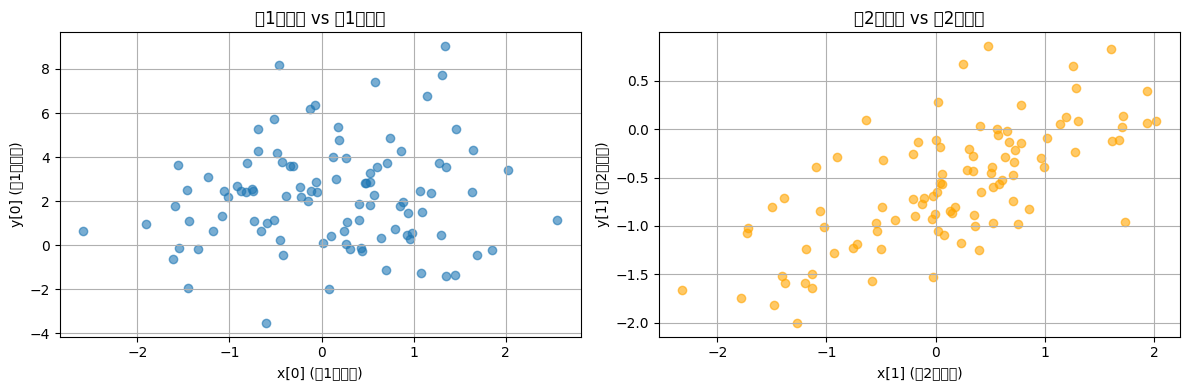

In [3]:
# 可视化训练数据（仅显示第一个特征和第一个输出）
plt.figure(figsize=(12, 4))

# 显示第一个特征与第一个输出的关系
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0].numpy(), y[:, 0].numpy(), alpha=0.6)
plt.xlabel('x[0] (第1个特征)')
plt.ylabel('y[0] (第1个输出)')
plt.title('第1个特征 vs 第1个输出')
plt.grid(True)

# 显示第二个特征与第二个输出的关系
plt.subplot(1, 2, 2)
plt.scatter(x[:, 1].numpy(), y[:, 1].numpy(), alpha=0.6, color='orange')
plt.xlabel('x[1] (第2个特征)')
plt.ylabel('y[1] (第2个输出)')
plt.title('第2个特征 vs 第2个输出')
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# 初始化模型参数
# requires_grad=True表示这些参数需要计算梯度
W = torch.randn(m_features, n_outputs, requires_grad=True)  # 权重矩阵 (m, n)
b = torch.randn(n_outputs, requires_grad=True)  # 偏置向量 (n,)

print(f"初始参数形状 - W: {W.shape}, b: {b.shape}")
print(f"W requires_grad: {W.requires_grad}")
print(f"b requires_grad: {b.requires_grad}")
print(f"初始权重矩阵 W:\n{W.detach().numpy()}")
print(f"初始偏置 b: {b.detach().numpy()}")

初始参数形状 - W: torch.Size([3, 2]), b: torch.Size([2])
W requires_grad: True
b requires_grad: True
初始权重矩阵 W:
[[ 0.06136708  0.46790215]
 [ 0.43584782 -0.28228024]
 [-1.2118933  -1.2612135 ]]
初始偏置 b: [-0.08296369 -0.6891635 ]


In [5]:
# 定义前向传播函数
def forward(x, w, b):
    """
    线性回归的前向传播
    y_pred = x * w + b
    """
    return torch.matmul(x, w) + b

# 测试前向传播
y_pred = forward(x, W, b)
print(f"预测值形状: {y_pred.shape}")
print(f"前几个预测值: {y_pred[:5].flatten().detach().numpy()}")

预测值形状: torch.Size([100, 2])
前几个预测值: [ 0.55105305  0.75165576 -1.6932231  -1.6294621  -0.8514884  -2.4021223
 -1.3548954  -1.9382765   0.22590537 -0.4920388 ]


In [6]:
# 定义损失函数（均方误差）
def mse_loss(y_pred, y_true):
    """
    计算均方误差损失
    Loss = (1/n) * sum((y_pred - y_true)^2)
    """
    return torch.mean((y_pred - y_true) ** 2)

# 测试损失函数
loss = mse_loss(y_pred, y)
print(f"初始损失: {loss.item():.4f}")
print(f"损失形状: {loss.shape}")
print(f"loss requires_grad: {loss.requires_grad}")

初始损失: 4.0572
损失形状: torch.Size([])
loss requires_grad: True


In [7]:
# 执行反向传播
print("执行backward前的梯度状态:")
print(f"W.grad: {W.grad}")
print(f"b.grad: {b.grad}")

# 计算梯度
loss.backward()

print("\n执行backward后的梯度:")
print(f"W.grad 形状: {W.grad.shape}")
print(f"W.grad:\n{W.grad}")
print(f"b.grad 形状: {b.grad.shape}")
print(f"b.grad: {b.grad}")

执行backward前的梯度状态:
W.grad: None
b.grad: None

执行backward后的梯度:
W.grad 形状: torch.Size([3, 2])
W.grad:
tensor([[-0.6018, -0.1014],
        [-0.2128, -0.7887],
        [ 0.8609, -1.0365]])
b.grad 形状: torch.Size([2])
b.grad: tensor([-2.3124, -0.1583])


In [8]:
# 手动验证梯度计算
print("=== 手动计算梯度 ===")
# 对于MSE损失：L = (1/n) * sum((y_pred - y)^2)
# 其中 y_pred = X @ W + b

# 计算损失对输出的梯度
diff = y_pred - y  # (n_samples, n_outputs)
print(f"预测误差 (y_pred - y) 形状: {diff.shape}")

# 损失对W的梯度: dL/dW = (2/n) * X^T @ (y_pred - y)
manual_grad_W = (2.0 / n_samples) * torch.matmul(x.t(), diff)
print(f"手动计算的W梯度形状: {manual_grad_W.shape}")
print(f"手动计算的W梯度:\n{manual_grad_W}")

# 损失对b的梯度: dL/db = (2/n) * sum(y_pred - y, axis=0)
manual_grad_b = (2.0 / n_samples) * torch.sum(diff, dim=0)
print(f"手动计算的b梯度: {manual_grad_b}")

print("\n=== 对比自动梯度和手动梯度 ===")
print(f"W梯度差异: {torch.max(torch.abs(W.grad - manual_grad_W)).item():.8f}")
print(f"b梯度差异: {torch.max(torch.abs(b.grad - manual_grad_b)).item():.8f}")

=== 手动计算梯度 ===
预测误差 (y_pred - y) 形状: torch.Size([100, 2])
手动计算的W梯度形状: torch.Size([3, 2])
手动计算的W梯度:
tensor([[-1.2036, -0.2027],
        [-0.4255, -1.5774],
        [ 1.7217, -2.0729]], grad_fn=<MulBackward0>)
手动计算的b梯度: tensor([-4.6247, -0.3166], grad_fn=<MulBackward0>)

=== 对比自动梯度和手动梯度 ===
W梯度差异: 1.03646755
b梯度差异: 2.31235504


In [9]:
# 参数更新（梯度下降）
learning_rate = 0.01

print("更新前的参数:")
print(f"W:\n{W.detach().numpy()}")
print(f"b: {b.detach().numpy()}")

# 手动更新参数（不使用优化器）
with torch.no_grad():
    W -= learning_rate * W.grad
    b -= learning_rate * b.grad

print(f"\n更新后的参数:")
print(f"W:\n{W.detach().numpy()}")
print(f"b: {b.detach().numpy()}")

# 清零梯度（为下次计算准备）
W.grad.zero_()
b.grad.zero_()
print("\n梯度已清零")

更新前的参数:
W:
[[ 0.06136708  0.46790215]
 [ 0.43584782 -0.28228024]
 [-1.2118933  -1.2612135 ]]
b: [-0.08296369 -0.6891635 ]

更新后的参数:
W:
[[ 0.06738532  0.46891567]
 [ 0.4379754  -0.274393  ]
 [-1.2205019  -1.2508489 ]]
b: [-0.05984014 -0.68758076]

梯度已清零


In [14]:
# 完整的训练循环
epochs = 1000
losses = []

# 重新初始化参数
W = torch.randn(m_features, n_outputs, requires_grad=True)
b = torch.randn(n_outputs, requires_grad=True)

print("开始训练...")
for epoch in range(epochs):
    # 前向传播
    y_pred = forward(x, W, b)
    
    # 计算损失
    loss = mse_loss(y_pred, y)
    losses.append(loss.item())
    
    # 清零梯度
    if W.grad is not None:
        W.grad.zero_()
    if b.grad is not None:
        b.grad.zero_()
    
    # 反向传播
    loss.backward()
    
    # 参数更新
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    # 打印进度
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print(f"\n训练完成！最终损失: {losses[-1]:.4f}")
print(f"学习到的参数 W:\n{W.detach().numpy()}")
print(f"学习到的参数 b: {b.detach().numpy()}")
print(f"真实参数 W:\n{true_W.numpy()}")
print(f"真实参数 b: {true_b.numpy()}")

开始训练...
Epoch 20/1000, Loss: 5.0970
Epoch 40/1000, Loss: 3.6202
Epoch 60/1000, Loss: 2.5762
Epoch 80/1000, Loss: 1.8367
Epoch 100/1000, Loss: 1.3119
Epoch 120/1000, Loss: 0.9390
Epoch 140/1000, Loss: 0.6735
Epoch 160/1000, Loss: 0.4842
Epoch 180/1000, Loss: 0.3492
Epoch 200/1000, Loss: 0.2527
Epoch 220/1000, Loss: 0.1837
Epoch 240/1000, Loss: 0.1344
Epoch 260/1000, Loss: 0.0990
Epoch 280/1000, Loss: 0.0736
Epoch 300/1000, Loss: 0.0554
Epoch 320/1000, Loss: 0.0423
Epoch 340/1000, Loss: 0.0330
Epoch 360/1000, Loss: 0.0262
Epoch 380/1000, Loss: 0.0213
Epoch 400/1000, Loss: 0.0179
Epoch 420/1000, Loss: 0.0153
Epoch 440/1000, Loss: 0.0135
Epoch 460/1000, Loss: 0.0122
Epoch 480/1000, Loss: 0.0113
Epoch 500/1000, Loss: 0.0106
Epoch 520/1000, Loss: 0.0101
Epoch 540/1000, Loss: 0.0098
Epoch 560/1000, Loss: 0.0095
Epoch 580/1000, Loss: 0.0093
Epoch 600/1000, Loss: 0.0092
Epoch 620/1000, Loss: 0.0091
Epoch 640/1000, Loss: 0.0090
Epoch 660/1000, Loss: 0.0090
Epoch 680/1000, Loss: 0.0089
Epoch 700/

/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/813167337.py:38: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/813167337.py:38: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/813167337.py:38: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/813167337.py:38: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4x7dkpqbbbhls03c0000gn/T/ipykernel_15921/813167337.py:38: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_y/7m5t3sbn4

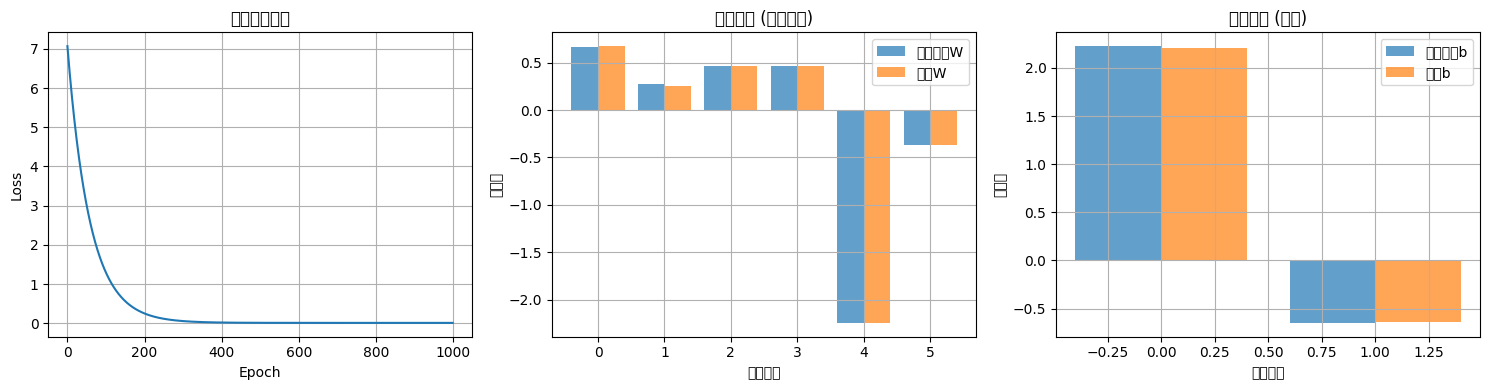

In [15]:
# 可视化训练过程和结果
plt.figure(figsize=(15, 4))

# 绘制损失曲线
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title('训练损失变化')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# 比较真实参数和学习到的参数（权重矩阵）
plt.subplot(1, 3, 2)
learned_W = W.detach().numpy()
true_W_np = true_W.numpy()
x_pos = np.arange(len(learned_W.flatten()))
plt.bar(x_pos - 0.2, learned_W.flatten(), 0.4, label='学习到的W', alpha=0.7)
plt.bar(x_pos + 0.2, true_W_np.flatten(), 0.4, label='真实W', alpha=0.7)
plt.title('参数对比 (权重矩阵)')
plt.xlabel('参数索引')
plt.ylabel('参数值')
plt.legend()
plt.grid(True)

# 比较真实参数和学习到的参数（偏置）
plt.subplot(1, 3, 3)
learned_b = b.detach().numpy()
true_b_np = true_b.numpy()
x_pos = np.arange(len(learned_b))
plt.bar(x_pos - 0.2, learned_b, 0.4, label='学习到的b', alpha=0.7)
plt.bar(x_pos + 0.2, true_b_np, 0.4, label='真实b', alpha=0.7)
plt.title('参数对比 (偏置)')
plt.xlabel('输出维度')
plt.ylabel('参数值')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()